# Bias Reduction

Climate models can have biases towards different references. Commonly, biases are reduced by postprocessing before verification of forecasting skill. `climpred` provides convenience functions to do so.

In [1]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble
hind = climpred.tutorial.load_dataset('CESM-DP-SST') # CESM-DPLE hindcast ensemble output.
obs = climpred.tutorial.load_dataset('ERSST') # ERSST observations.
recon = climpred.tutorial.load_dataset('FOSI-SST') # Reconstruction simulation that initialized CESM-DPLE.
hind["lead"].attrs["units"] = "years"
v='SST'

In [2]:
hindcast = HindcastEnsemble(hind)
# choose one observation
hindcast = hindcast.add_observations(recon, 'reconstruction')
#hindcast = hindcast.add_observations(obs, 'ERSST') # fits hind better than reconstruction

/Users/ribr5703/miniconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


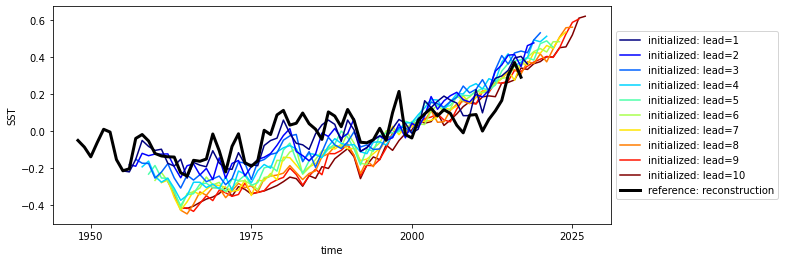

In [3]:
# always only subtract a PredictionEnsemble from another PredictionEnsemble if you handle time and init at the same time
# compute anomaly with respect to 1964-2014
hindcast = hindcast - hindcast.sel(time=slice('1964', '2014')).mean('time').sel(init=slice('1964', '2014')).mean('init')
hindcast.plot()

The warming of the `reconstruction` is less than the `initialized`.

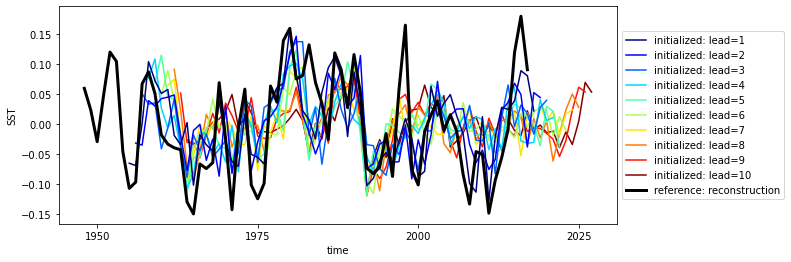

In [4]:
# only little lead-time dependent bias left after detrending
from esmtools.stats import rm_poly
order=2
hindcast = hindcast.apply(rm_poly, dim='init', order=order).apply(rm_poly, dim='time', order=order)
hindcast.plot()

## Mean bias reduction

Typically, bias depends on lead-time and therefore should therefore also be removed depending on lead-time.

In [5]:
# build bias_metric by hand
from climpred.metrics import Metric
def bias_func(a,b,**kwargs):
    return a-b
bias_metric = Metric('bias', bias_func, True, False,1)

In [6]:
bias = hindcast.verify(metric=bias_metric, comparison='e2r', dim='init').squeeze()

In [7]:
# equals using the pre-defined (unconditional) bias metric applied to over dimension member
xr.testing.assert_allclose(bias, hindcast.verify(metric='unconditional_bias', comparison='m2r',dim='member').squeeze())

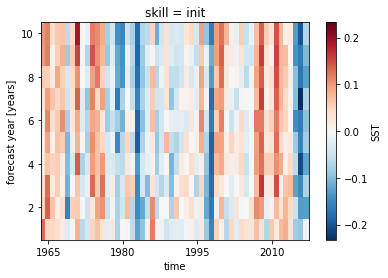

In [8]:
bias[v].plot()

- against Reconstruction: Cold bias in early years and warm bias in later years.
- against ERSST: Overall cold bias.

### quick

In [9]:
def _mean_bias_reduction_quick(hind, bias, dim):
    """Quick reduction of mean bias over all initializations."""
    bias_reduced_hind = hind - bias.mean(dim)
    return bias_reduced_hind

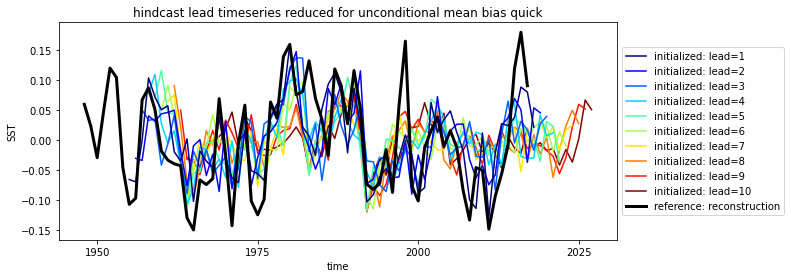

In [10]:
bias_reduced_hind_quick = _mean_bias_reduction_quick(hindcast._datasets['initialized'], bias, 'time')

hindcast_bias_reduced_quick = hindcast.copy()
hindcast_bias_reduced_quick._datasets['initialized'] = bias_reduced_hind_quick

hindcast_bias_reduced_quick.plot()
plt.title('hindcast lead timeseries reduced for unconditional mean bias quick')
plt.show()

## properly

In [11]:
def _mean_bias_reduction_properly(hind, bias, dim):
    """Reduce mean bias from all but the given initialization in a cross-validation approach.
    
    Reference:
    - Jolliffe, Ian T., and David B. Stephenson. Forecast Verification: A Practitioner’s Guide
      in Atmospheric Science. Chichester, UK: John Wiley & Sons, Ltd, 2011.
      https://doi.org/10.1002/9781119960003., Chapter: 5.3.1, p.80
    """
    bias = bias.rename({dim:'init'})
    bias_reduced_hind = []
    for init in hind.init.values:
        hind_drop_init = hind.init.drop_sel(init=init)
        hind_drop_init_where_bias = hind_drop_init.where(bias.init)
        bias_reduced_hind.append(hind.sel(init=init) - bias.sel(init=hind_drop_init_where_bias).mean('init'))
    bias_reduced_hind = xr.concat(bias_reduced_hind,'init')
    return bias_reduced_hind

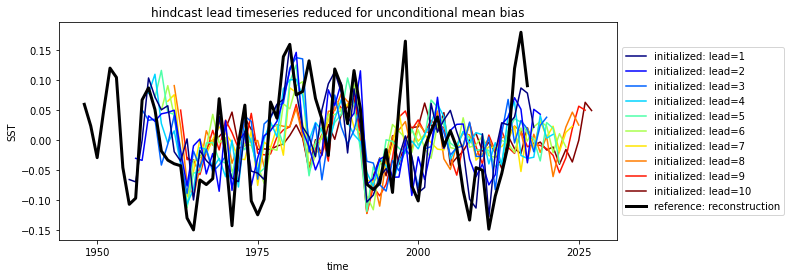

In [12]:
bias_reduced_hind = _mean_bias_reduction_properly(hindcast._datasets['initialized'], bias, 'time').squeeze()

hindcast_bias_reduced = hindcast.copy()
hindcast_bias_reduced._datasets['initialized'] = bias_reduced_hind

hindcast_bias_reduced.plot()
plt.title('hindcast lead timeseries reduced for unconditional mean bias')
plt.show()

`climpred` wraps these functions in `HindcastEnsemble.reduce_bias(how='mean')`.

# Skill

Distance-based accuracy metrics like (`mse`,`rmse`,`nrmse`,...) are sensitive to mean bias reduction.

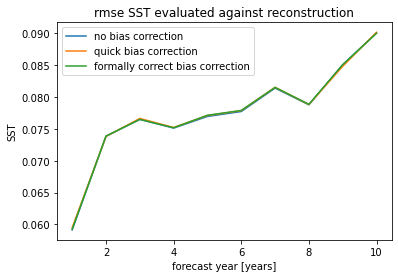

In [13]:
metric='rmse'
hindcast.verify(metric=metric)[v].plot(label='no bias correction')
hindcast.reduce_bias(cross_validate=False, alignment='maximize').verify(metric=metric)[v].plot(label='quick bias correction')
hindcast.reduce_bias(cross_validate=True, alignment='maximize').verify(metric=metric)[v].plot(label='formally correct bias correction')
plt.legend()
plt.title(f"{metric} {v} evaluated against {list(hindcast._datasets['observations'].keys())[0]}")
plt.show()